# Summer of Code - Artificial Intelligence

## Week 09: Deep Learning

### Day 05: Word Embeddings

In this notebook, we will learn about various word embedding techniques like **Word2Vec**, **GloVe**, **Continuous Bag of Words (CBOW)**, and **Skip-Gram**. Word embeddings are a type of word representation that allows words to be represented as vectors in a continuous vector space, capturing semantic relationships between words.


In [46]:
# Tiny corpus
docs = [
    "the quick brown fox jumps over the lazy dog",
    "the quick blue hare jumps under the bright sun",
    "dogs and foxes are quick and smart",
    "the lazy dog sleeps under the bright sun",
    "foxes are smart and quick", 
    "the brown hare jumps over the lazy dog",
    "dogs are quick and smart",
    "the fox jumps over the lazy dog",
    "hare and fox are quick",
    "the sun is bright and blue",
    "lazy dogs sleep under the sun",
    "quick foxes jump over dogs",
    "the brown fox is smart",
    "hare jumps under the sun",
    "dogs and hare are quick",
]
len(docs)

15

In [47]:
import spacy

nlp = spacy.load("en_core_web_sm")

doc_tokens = [
    [token.lemma_ for token in nlp(doc) if not token.is_punct]
    for doc in docs
]
doc_tokens

[['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazy', 'dog'],
 ['the', 'quick', 'blue', 'hare', 'jump', 'under', 'the', 'bright', 'sun'],
 ['dog', 'and', 'fox', 'be', 'quick', 'and', 'smart'],
 ['the', 'lazy', 'dog', 'sleep', 'under', 'the', 'bright', 'sun'],
 ['fox', 'be', 'smart', 'and', 'quick'],
 ['the', 'brown', 'hare', 'jump', 'over', 'the', 'lazy', 'dog'],
 ['dog', 'be', 'quick', 'and', 'smart'],
 ['the', 'fox', 'jump', 'over', 'the', 'lazy', 'dog'],
 ['hare', 'and', 'fox', 'be', 'quick'],
 ['the', 'sun', 'be', 'bright', 'and', 'blue'],
 ['lazy', 'dog', 'sleep', 'under', 'the', 'sun'],
 ['quick', 'fox', 'jump', 'over', 'dog'],
 ['the', 'brown', 'fox', 'be', 'smart'],
 ['hare', 'jump', 'under', 'the', 'sun'],
 ['dog', 'and', 'hare', 'be', 'quick']]

In [48]:
vocab = sorted({token for doc in doc_tokens for token in doc})
print(vocab)

['and', 'be', 'blue', 'bright', 'brown', 'dog', 'fox', 'hare', 'jump', 'lazy', 'over', 'quick', 'sleep', 'smart', 'sun', 'the', 'under']


In [49]:
t2i = {token:token_id for token_id, token in enumerate(vocab)}
t2i


{'and': 0,
 'be': 1,
 'blue': 2,
 'bright': 3,
 'brown': 4,
 'dog': 5,
 'fox': 6,
 'hare': 7,
 'jump': 8,
 'lazy': 9,
 'over': 10,
 'quick': 11,
 'sleep': 12,
 'smart': 13,
 'sun': 14,
 'the': 15,
 'under': 16}

In [50]:
i2t = {token_id:token for token_id, token in enumerate(vocab)}
i2t


{0: 'and',
 1: 'be',
 2: 'blue',
 3: 'bright',
 4: 'brown',
 5: 'dog',
 6: 'fox',
 7: 'hare',
 8: 'jump',
 9: 'lazy',
 10: 'over',
 11: 'quick',
 12: 'sleep',
 13: 'smart',
 14: 'sun',
 15: 'the',
 16: 'under'}

In [51]:
V = len(vocab)
V


17

In [ ]:
import torch
import numpy as np


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
rng = np.random.default_rng(42)


# Continuous Bag of Words
The Continuous Bag of Words (CBOW) model predicts a target word based on its surrounding context words. It takes the context words as input and tries to predict the target word. The model learns to represent words in a vector space such that words with similar contexts have similar vector representations.

<img src="images/cboww.png" alt="CBOW Model" width="800"/>

In [55]:
t2i['dog']

5

In [57]:
# Generate CBOW training pairs: (context_ids, target_id)
def generate_cbow_training(documents, window=3):
    pairs = []
    for doc in documents:
        for i, center in enumerate(doc):
            target_id = t2i[center]
            context_ids = []
            for j in range(max(0, i-window), min(len(doc), i+window+1)):
                if j != i:
                    context_ids.append(t2i[doc[j]])
            if context_ids:
                pairs.append((context_ids, target_id))
    return pairs

pairs = generate_cbow_training(doc_tokens, window=3)

In [59]:
print(len(pairs))
print(pairs[:5])

95
[([11, 4, 6], 15), ([15, 4, 6, 8], 11), ([15, 11, 6, 8, 10], 4), ([15, 11, 4, 8, 10, 15], 6), ([11, 4, 6, 10, 15, 9], 8)]


In [61]:
# print pairs as strings
for context_ids, target_id in pairs[:5]:
    context_words = [i2t[cid] for cid in context_ids]
    target_word = i2t[target_id]
    print(f"Context: {context_words} -> Target: {target_word}")

Context: ['quick', 'brown', 'fox'] -> Target: the
Context: ['the', 'brown', 'fox', 'jump'] -> Target: quick
Context: ['the', 'quick', 'fox', 'jump', 'over'] -> Target: brown
Context: ['the', 'quick', 'brown', 'jump', 'over', 'the'] -> Target: fox
Context: ['quick', 'brown', 'fox', 'over', 'the', 'lazy'] -> Target: jump


In [62]:
# Convert to tensors
contexts = [torch.tensor(context_ids, dtype=torch.long) for context_ids,target_id in pairs]
targets = torch.tensor([target_id for context_ids, target_id in pairs], dtype=torch.long)
contexts[0], targets[0]

(tensor([11,  4,  6]), tensor(15))

In [66]:
# padd the tensors to have same length
from torch.nn.utils.rnn import pad_sequence


padded_contexts = pad_sequence(contexts, batch_first=True, padding_value=0)
padded_contexts.shape

torch.Size([95, 6])

In [67]:
padded_contexts = [context for context in padded_contexts]
padded_contexts[:5]

[tensor([11,  4,  6,  0,  0,  0]),
 tensor([15,  4,  6,  8,  0,  0]),
 tensor([15, 11,  6,  8, 10,  0]),
 tensor([15, 11,  4,  8, 10, 15]),
 tensor([11,  4,  6, 10, 15,  9])]

In [68]:
# DataLoader
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(torch.stack(padded_contexts), targets)
dataset[0]

(tensor([11,  4,  6,  0,  0,  0]), tensor(15))

In [69]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
len(dataloader)

48

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## CBOW Model

<img src="images/cbow_model.png" alt="CBOW Model Architecture" width="900"/>

In [71]:
from torch import nn

# CBOW Model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, contexts):
        # Average context embeddings
        embeds = self.embeddings(contexts).mean(dim=1)
        out = self.linear(embeds)
        return out

embed_dim = 8
model = CBOW(V, embed_dim)
model.to(device)

CBOW(
  (embeddings): Embedding(17, 8)
  (linear): Linear(in_features=8, out_features=17, bias=True)
)

In [73]:
from torchinfo import summary

input_sample = torch.zeros(1, 6, dtype=torch.long, device=device)
summary(model, input_data=input_sample)

Layer (type:depth-idx)                   Output Shape              Param #
CBOW                                     [1, 17]                   --
├─Embedding: 1-1                         [1, 6, 8]                 136
├─Linear: 1-2                            [1, 17]                   153
Total params: 289
Trainable params: 289
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [76]:
# Extract embeddings
cbow_embeddings = model.embeddings.weight.detach().cpu().numpy()
cbow_embeddings.shape

(17, 8)

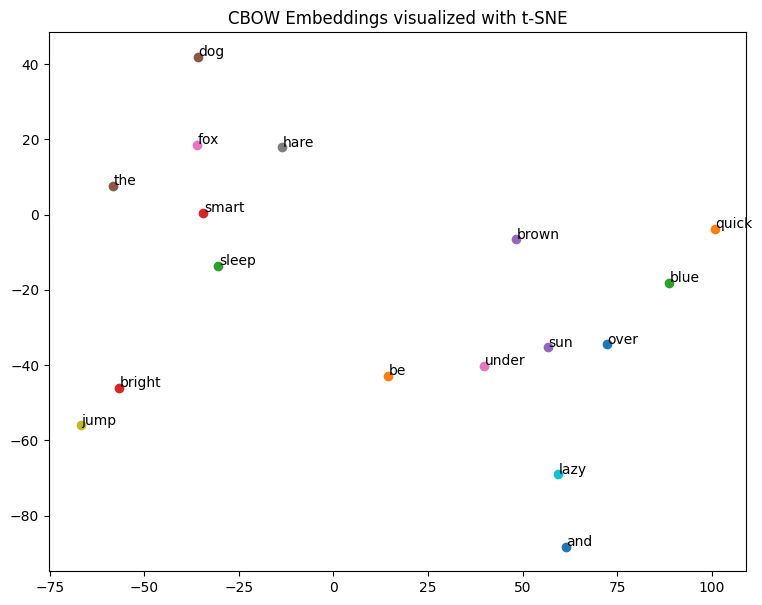

In [78]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=3)
embed_2d = tsne.fit_transform(cbow_embeddings)

plt.figure(figsize=(9, 7))
for i, word in enumerate(vocab):
    plt.scatter(embed_2d[i, 0], embed_2d[i, 1])
    plt.text(embed_2d[i, 0] + 0.1, embed_2d[i, 1] + 0.1, word)
plt.title("CBOW Embeddings visualized with t-SNE")
plt.show()

In [79]:
from torch import optim


optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_losses = []

# Training
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for context, target in dataloader:
        context, target = context.to(device), target.to(device)

        output = model(context)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss/len(dataloader))
    if (epoch + 1) % 10 == 0:
        print(f"epoch {epoch+1}: loss={total_loss/len(dataloader):.3f}")


epoch 10: loss=2.678
epoch 20: loss=2.564
epoch 30: loss=2.476
epoch 40: loss=2.419
epoch 50: loss=2.342
epoch 60: loss=2.291
epoch 70: loss=2.225
epoch 80: loss=2.175
epoch 90: loss=2.118
epoch 100: loss=2.068


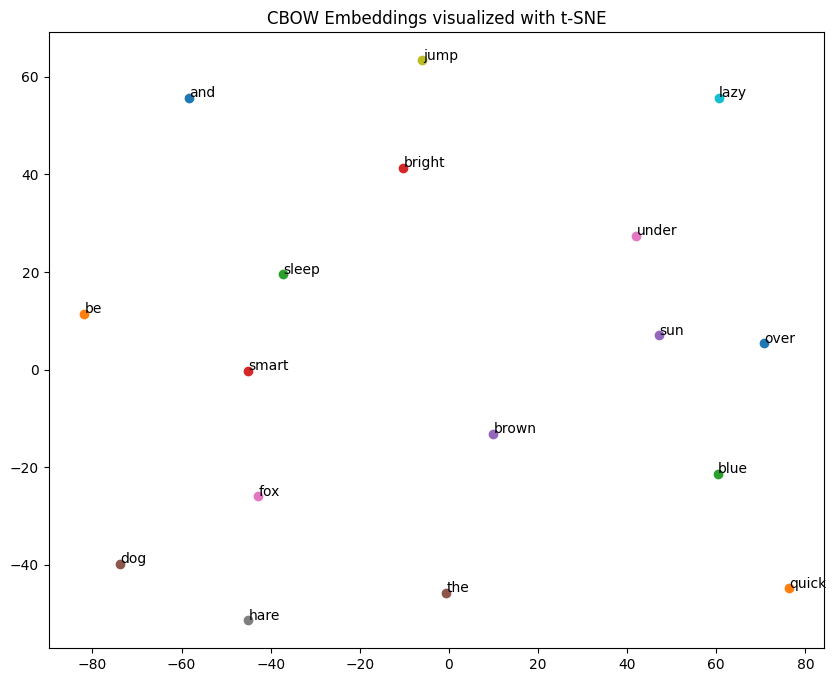

In [80]:
# Extract embeddings
cbow_embeddings = model.embeddings.weight.detach().cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embed_2d = tsne.fit_transform(cbow_embeddings)

plt.figure(figsize=(10, 8))
for i, word in enumerate(vocab):
    plt.scatter(embed_2d[i, 0], embed_2d[i, 1])
    plt.text(embed_2d[i, 0] + 0.1, embed_2d[i, 1] + 0.1, word)
plt.title('CBOW Embeddings visualized with t-SNE')
plt.show()

# Skip-Gram
The Skip-Gram model works in the opposite way to CBOW. It takes a target word as input and tries to predict the surrounding context words. The model learns to represent words in a vector space such that words that appear in similar contexts have similar vector representations.

<img src="images/skipgram.png" alt="Skip-Gram Model" width="800"/>

In [81]:
def generate_skipgram_training(tokens, window=2):
    pairs = []
    for doc in tokens:
        for i, w in enumerate(doc):
            target_id = t2i[w]
            for j in range(max(0, i-window), min(len(doc), i+window+1)):
                if j == i:
                    continue
                pairs.append((target_id, t2i[doc[j]]))
    return pairs

sg_pairs = generate_skipgram_training(doc_tokens, window=2)
len(sg_pairs), sg_pairs[:3]


(290, [(15, 11), (15, 4), (11, 15)])

In [82]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embed_dim, max_norm=1
        )
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.fc2 = nn.Linear(embed_dim, vocab_size)

    def forward(self, targets):
        embeds = self.embeddings(targets)
        out = self.fc2(self.fc1(embeds))
        return out


# Prepare Skip-Gram data
targets = torch.tensor([t for t, c in sg_pairs], dtype=torch.long)
contexts = torch.tensor([c for t, c in sg_pairs], dtype=torch.long)
targets[:5], contexts[:5]

(tensor([15, 15, 11, 11, 11]), tensor([11,  4, 15,  4,  6]))

In [83]:

sg_dataset = TensorDataset(targets, contexts)
sg_dataloader = DataLoader(sg_dataset, batch_size=1, shuffle=True)

# Initialize model
embed_dim = 16
sg_model = SkipGram(V, embed_dim)
sg_model.to(device)


SkipGram(
  (embeddings): Embedding(17, 16, max_norm=1)
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=17, bias=True)
)

In [84]:
input_sample = torch.zeros(1, dtype=torch.long, device=device)
summary(sg_model, input_data=input_sample)

Layer (type:depth-idx)                   Output Shape              Param #
SkipGram                                 [1, 17]                   --
├─Embedding: 1-1                         [1, 16]                   272
├─Linear: 1-2                            [1, 16]                   272
├─Linear: 1-3                            [1, 17]                   289
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

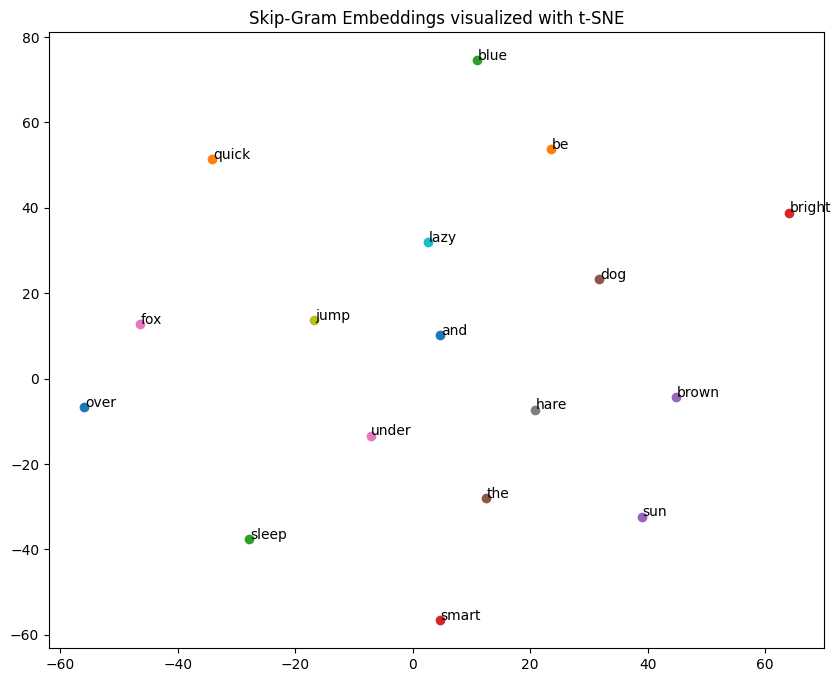

In [85]:
skipgram_embeddings = sg_model.embeddings.weight.detach().cpu().numpy()

# Visualize
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embed_2d = tsne.fit_transform(skipgram_embeddings)

plt.figure(figsize=(10, 8))
for i, word in enumerate(vocab):
    plt.scatter(embed_2d[i, 0], embed_2d[i, 1])
    plt.text(embed_2d[i, 0] + 0.1, embed_2d[i, 1] + 0.1, word)
plt.title("Skip-Gram Embeddings visualized with t-SNE")
plt.show()

epoch 2: loss=2.835
epoch 4: loss=2.821
epoch 6: loss=2.809
epoch 8: loss=2.797
epoch 10: loss=2.787
epoch 12: loss=2.778
epoch 14: loss=2.769
epoch 16: loss=2.761
epoch 18: loss=2.754
epoch 20: loss=2.747
epoch 22: loss=2.741
epoch 24: loss=2.736
epoch 26: loss=2.730
epoch 28: loss=2.725
epoch 30: loss=2.721
epoch 32: loss=2.716
epoch 34: loss=2.712
epoch 36: loss=2.708
epoch 38: loss=2.704
epoch 40: loss=2.700
epoch 42: loss=2.697
epoch 44: loss=2.693
epoch 46: loss=2.690
epoch 48: loss=2.686
epoch 50: loss=2.683
epoch 52: loss=2.679
epoch 54: loss=2.676
epoch 56: loss=2.672
epoch 58: loss=2.669
epoch 60: loss=2.665
epoch 62: loss=2.662
epoch 64: loss=2.658
epoch 66: loss=2.654
epoch 68: loss=2.650
epoch 70: loss=2.647
epoch 72: loss=2.643
epoch 74: loss=2.639
epoch 76: loss=2.635
epoch 78: loss=2.631
epoch 80: loss=2.626
epoch 82: loss=2.622
epoch 84: loss=2.618
epoch 86: loss=2.613
epoch 88: loss=2.609
epoch 90: loss=2.604
epoch 92: loss=2.599
epoch 94: loss=2.594
epoch 96: loss=2.

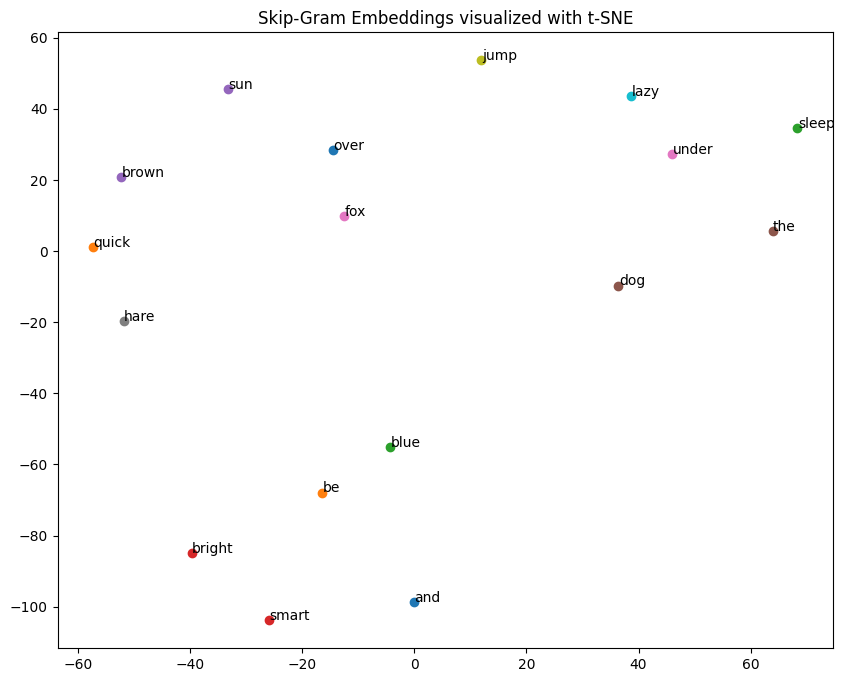

In [86]:
# Optimizer and criterion
sg_optimizer = optim.SGD(sg_model.parameters(), lr=0.001)
sg_criterion = nn.CrossEntropyLoss()

# Training
sg_num_epochs = 150
for epoch in range(sg_num_epochs):
    total_loss = 0
    for target, context in sg_dataloader:
        target, context = target.to(device), context.to(device)

        output = sg_model(target)
        loss = sg_criterion(output, context)

        sg_optimizer.zero_grad()
        loss.backward()
        sg_optimizer.step()

        total_loss += loss.item()
    if (epoch + 1) % 2 == 0:
        print(f"epoch {epoch+1}: loss={total_loss/len(sg_dataloader):.3f}")

# Extract embeddings
skipgram_embeddings = sg_model.embeddings.weight.detach().cpu().numpy()

# Visualize
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embed_2d = tsne.fit_transform(skipgram_embeddings)

plt.figure(figsize=(10, 8))
for i, word in enumerate(vocab):
    plt.scatter(embed_2d[i, 0], embed_2d[i, 1])
    plt.text(embed_2d[i, 0] + 0.1, embed_2d[i, 1] + 0.1, word)
plt.title("Skip-Gram Embeddings visualized with t-SNE")
plt.show()

In [90]:
import torch.nn.functional as F

torch.manual_seed(42)

vocab_size, dim = skipgram_embeddings.shape

# Convert numpy array to tensor
cbow_embeddings = torch.tensor(cbow_embeddings)

# pick random index
# idx = int(torch.randint(0, vocab_size, (1,)).item())
idx = 5
target = cbow_embeddings[idx].unsqueeze(0)

# normalized cosine similarities
emb_norm = F.normalize(cbow_embeddings, p=2, dim=1)
target_norm = F.normalize(target, p=2, dim=1)
sims = (emb_norm @ target_norm.t()).squeeze(1)

# exclude self and get top-5
sims[idx] = -float("inf")
topk = sims.topk(5)

print(f"Random index: {idx}")
print(f"Word: {i2t.get(idx, '<UNK>')}\n")
print("Top 5 most similar words (cosine):")
for rank, (sim_val, i) in enumerate(
    zip(topk.values.tolist(), topk.indices.tolist()), start=1
):
    print(f"{rank}. {i2t.get(int(i), '<UNK>')} (idx={int(i)})  sim={sim_val:.4f}")

Random index: 5
Word: dog

Top 5 most similar words (cosine):
1. fox (idx=6)  sim=0.7140
2. hare (idx=7)  sim=0.6917
3. smart (idx=13)  sim=0.6638
4. under (idx=16)  sim=0.4466
5. be (idx=1)  sim=0.4147


In [89]:
i2t

{0: 'and',
 1: 'be',
 2: 'blue',
 3: 'bright',
 4: 'brown',
 5: 'dog',
 6: 'fox',
 7: 'hare',
 8: 'jump',
 9: 'lazy',
 10: 'over',
 11: 'quick',
 12: 'sleep',
 13: 'smart',
 14: 'sun',
 15: 'the',
 16: 'under'}